# Элементарные методы анализа временных рядов

In [1]:
import pandas as pd
import numpy as np

In [15]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

# def plot_dema(alpha, beta):
#     dema = double_ema(sales_of_company_x["Count"], alpha, beta)
#     with plt.style.context('bmh'):
#         plt.figure(figsize=(14, 8))
#         plt.plot(sales_of_company_x["Count"], color='blue',label='original')
#         plt.plot(dema, color='red', linewidth='4', label='DEMA')
#         plt.title("alpha={}, beta={}".format(alpha, beta))
#         plt.legend()
        
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
#     tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
#     with plt.style.context('bmh'):
#         plt.figure(figsize=(14, 8))
#         plt.plot(ser_to_plot, color='blue',label='original')
#         plt.plot(tema, color='red', linewidth='4', label='TEMA')
#         plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
#         plt.legend()       
        

In [5]:
airlines_passengers = pd.read_csv('international-airline-passengers.csv')['Count']
female_births = pd.read_csv('daily-total-female-births-in-cal.csv')['Count']

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers,
    "Daily total female births in California": female_births
}

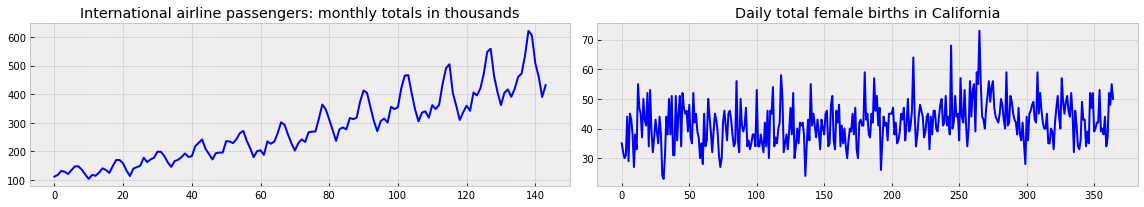

In [13]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

### Посмотрим на варианты скользящих средних для нестационарных данных датасета airlines_passengers

# Скользящее среднее

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо просто предсказания вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

В данном случае $\hat{y}_{t}$ называется скользящей средней

In [22]:
ser = moving_average(airlines_passengers, 5)

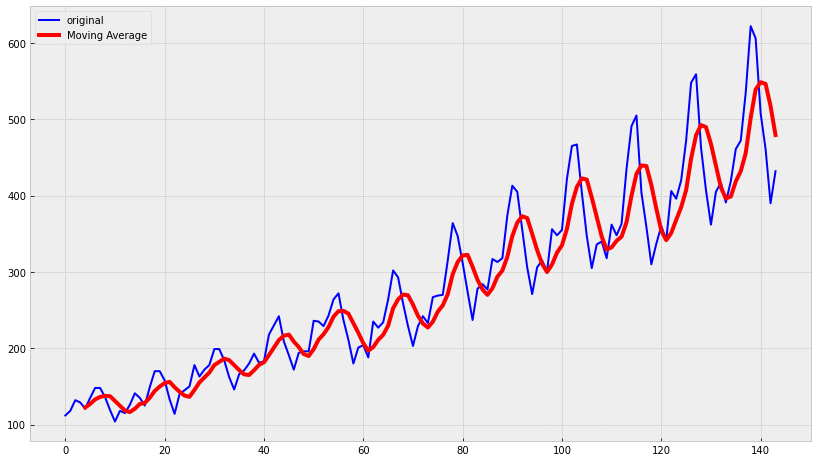

In [23]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Чем больше размер "окна" скользящего среднего $n$ тем более сглаженным получается результат. По нескольким скользящим средним можно увидеть периоды резкого роста и резкого спада.

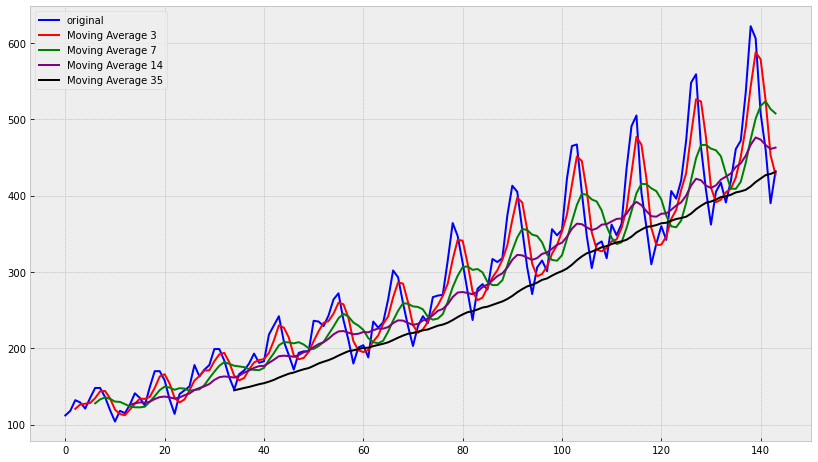

In [24]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(airlines_passengers, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Характерная особенность обычного скользящего среднего - повышенная чувствительность к выбросам данных

В случае сильно зашумленных данных скользящее среднее помогает определить тренд

### Модификацией обычной скользящей средней является взвешенная скользящая средняя.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

$\displaystyle\sum^{k}_{n=1} {\omega_n} = 1$

Обычно чем ближе измерение к прогнозируемому - тем больше его вес

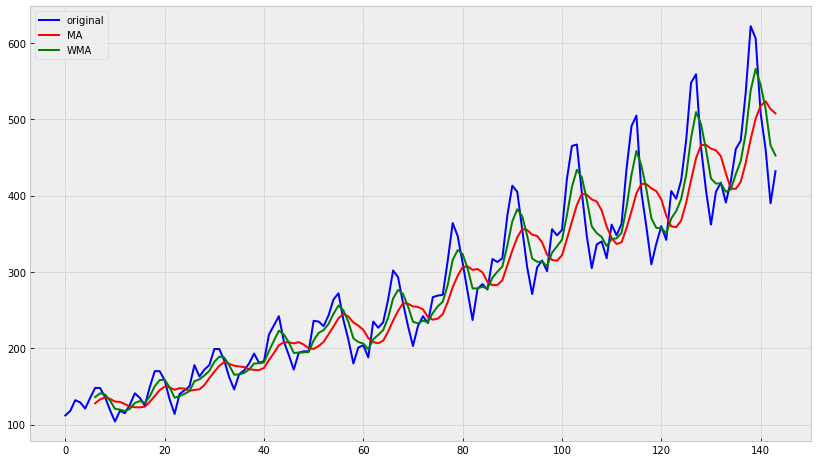

In [26]:
wma = weighted_moving_average(airlines_passengers, 7, [1,1,2,3,5,8,13])
ma = moving_average(airlines_passengers, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Такая вариация moving average позволяет учитывать временной контекст. Чем раньше было событие - тем меньше оно влияет на прогнозируемое событие

# Экспоненциальное сглаживание

Продолжаем развивать идею с историей. Мы хотим учитывать на самом деле учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное срденее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 

In [25]:
ema = exponential_moving_average(airlines_passengers, 0.2)

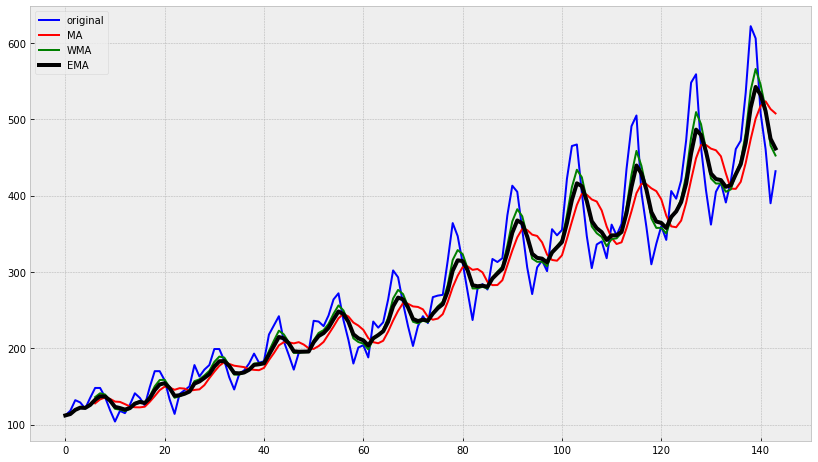

In [27]:
ema = exponential_moving_average(airlines_passengers, 0.3)
wma = weighted_moving_average(airlines_passengers, 7, [1,1,2,3,5,8,13])
ma = moving_average(airlines_passengers, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

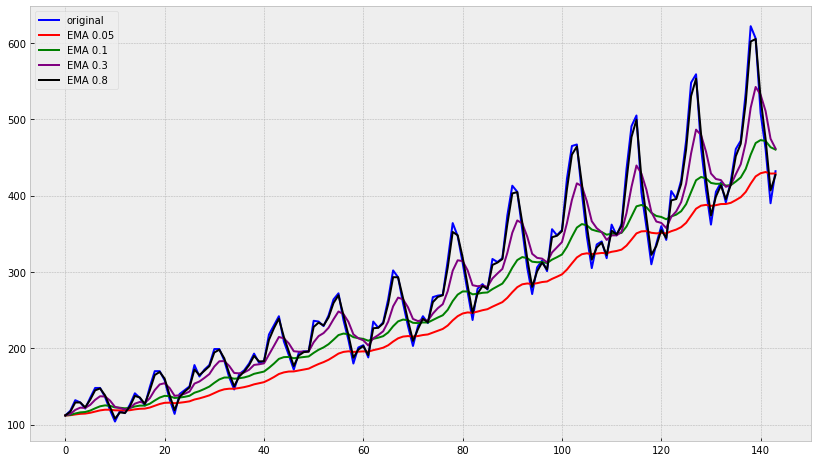

In [28]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(airlines_passengers, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

# Двойное экспоненциальное сглаживание

$$\hat{y}_t=l_t + s_t$$

$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$

$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$

До сих пор мы рассматривали ряд - как единую составляющую. Но на самом деле, ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [29]:
def plot_dema(alpha, beta):
    dema = double_ema(airlines_passengers, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(airlines_passengers, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

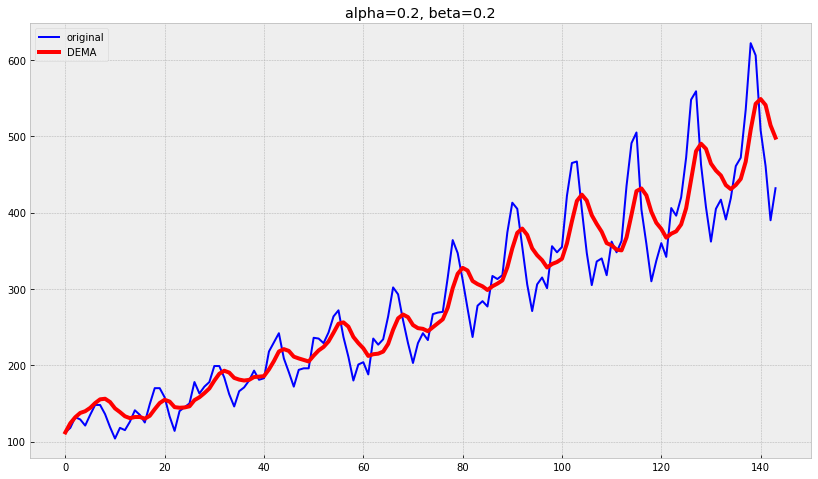

In [30]:
plot_dema(0.2, 0.2)

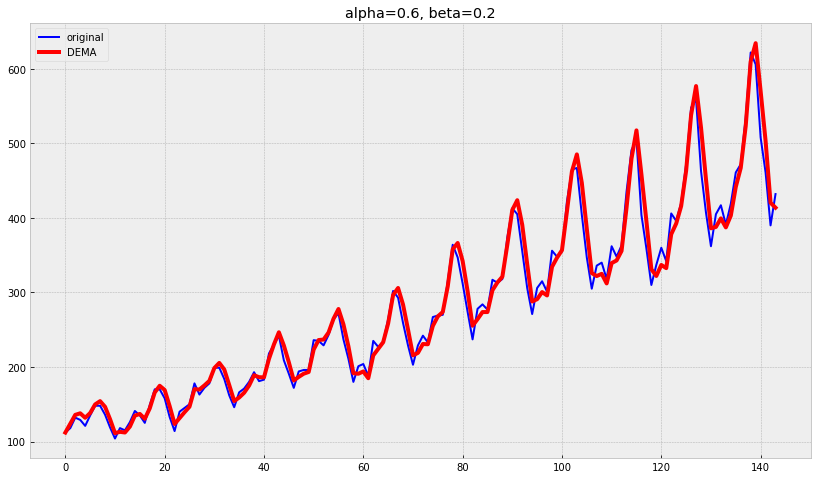

In [31]:
plot_dema(0.6, 0.2)

Как мы видим, настройка параметров $\alpha$ и $\beta$ может порой давать самые причудливые результаты. $\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

In [34]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [35]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

### Тройное экспоненциальное сглаживание

In [36]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers, ser_to_plot=airlines_passengers, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

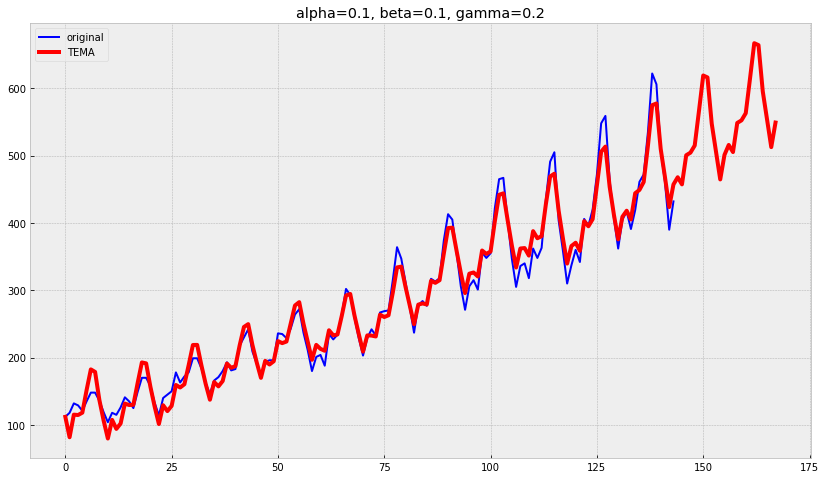

In [37]:
plot_tema(0.1, 0.1, 0.2)

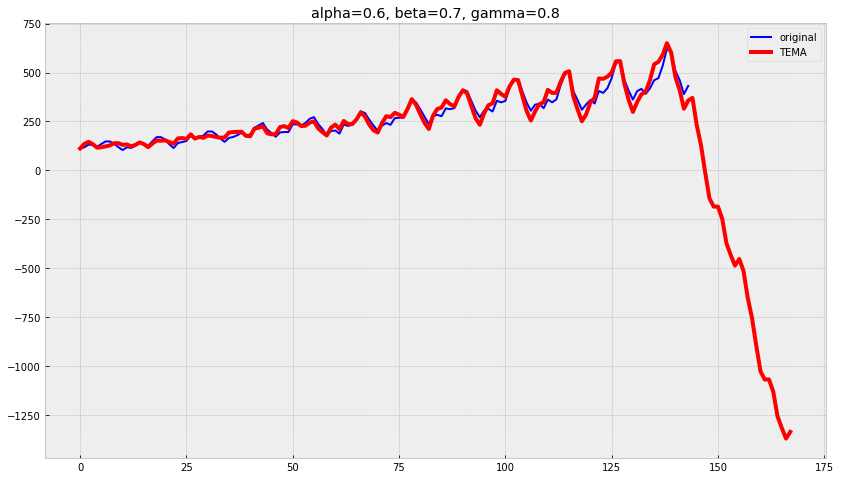

In [38]:
plot_tema(0.6, 0.7, 0.8)

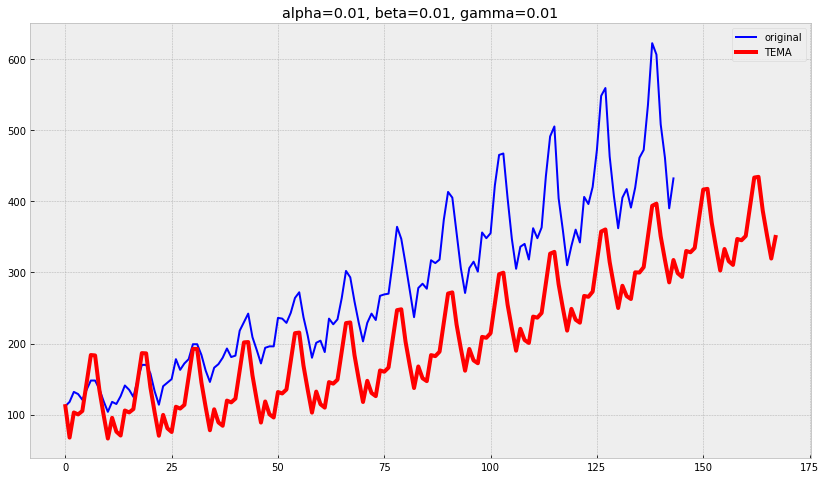

In [39]:
plot_tema(0.01, 0.01, 0.01)

### Посмотрим на варианты скользящих средних для стационарных данных датасета female_births

### Скользящее среднее

In [41]:
ser = moving_average(female_births, 5)

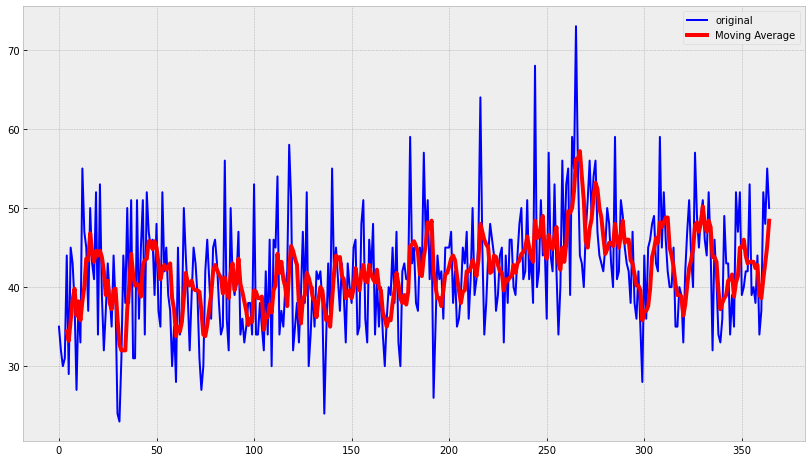

In [42]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

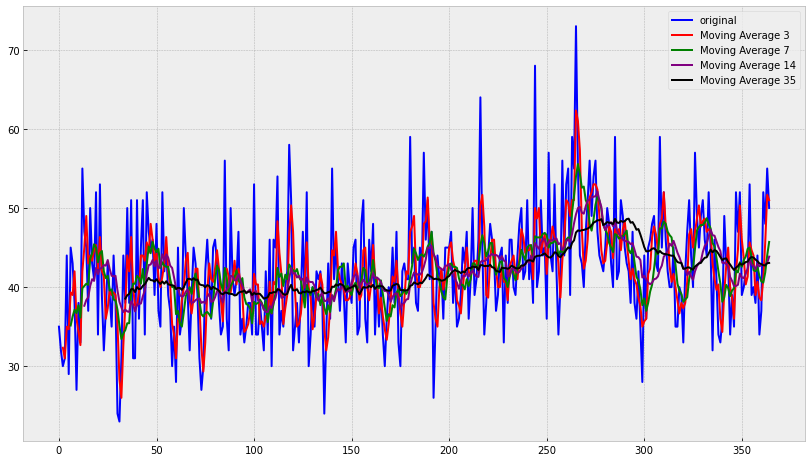

In [43]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(female_births, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Характерная особенность обычного скользящего среднего - повышенная чувствительность к выбросам данных

В случае сильно зашумленных данных скользящее среднее помогает определить тренд

### Взвешенная скользящая средняя.

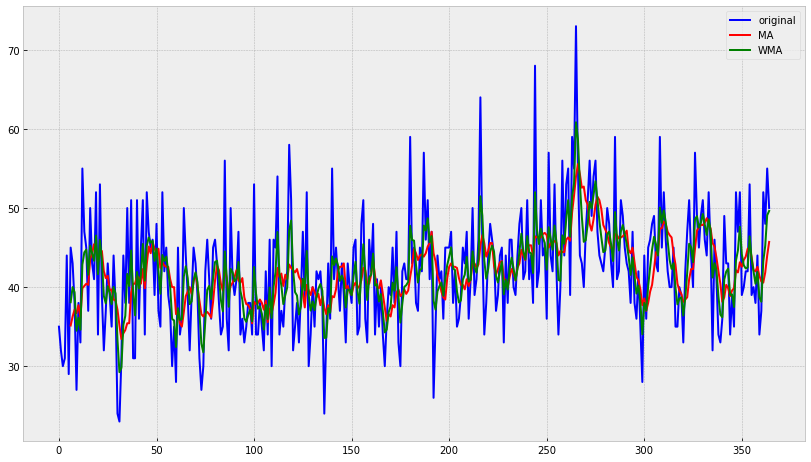

In [44]:
wma = weighted_moving_average(female_births, 7, [1,1,2,3,5,8,13])
ma = moving_average(female_births, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

# Экспоненциальное сглаживание

In [45]:
ema = exponential_moving_average(female_births, 0.2)

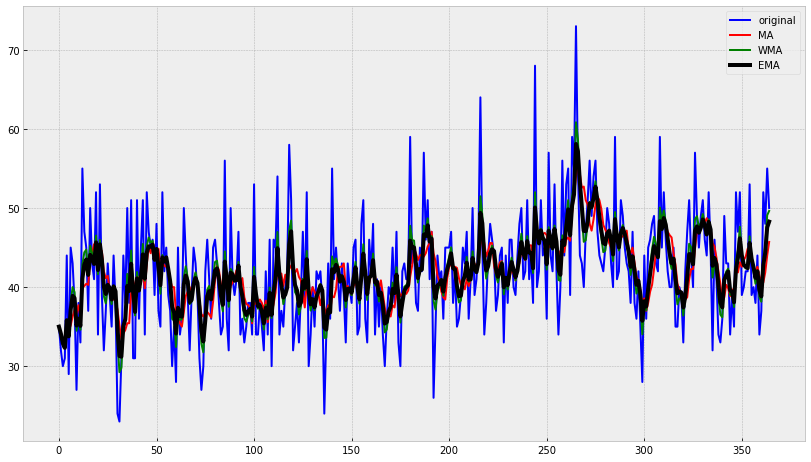

In [46]:
ema = exponential_moving_average(female_births, 0.3)
wma = weighted_moving_average(female_births, 7, [1,1,2,3,5,8,13])
ma = moving_average(female_births, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

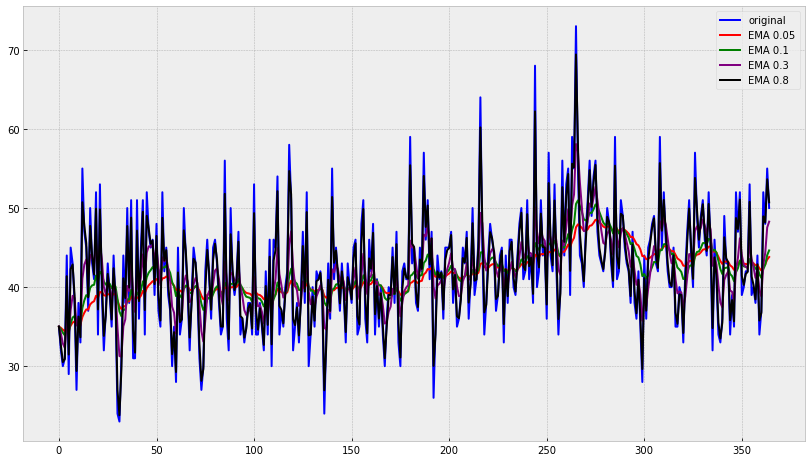

In [47]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(female_births, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

# Двойное экспоненциальное сглаживание

In [48]:
def plot_dema(alpha, beta):
    dema = double_ema(female_births, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(female_births, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

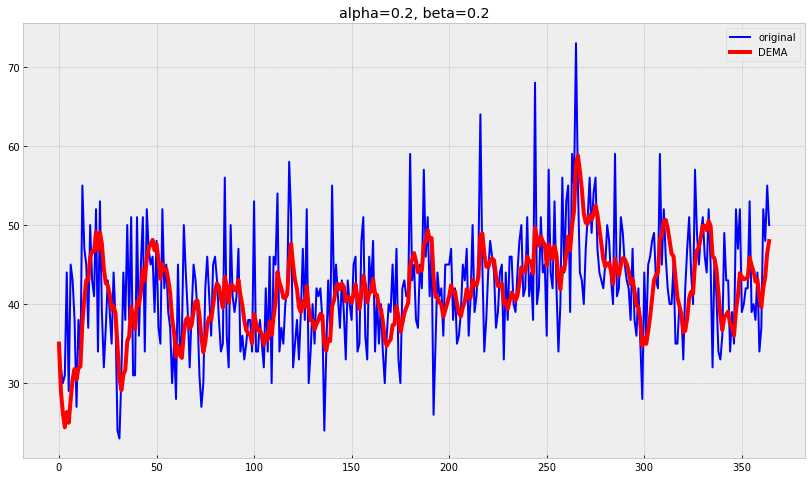

In [49]:
plot_dema(0.2, 0.2)

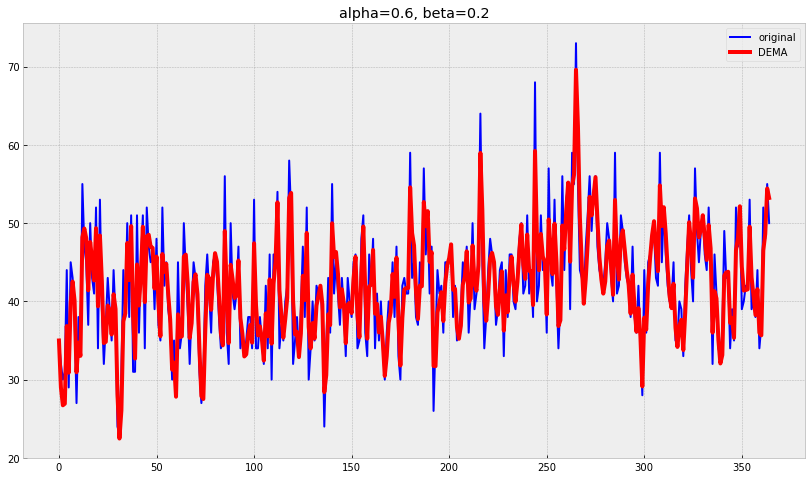

In [50]:
plot_dema(0.6, 0.2)

Как мы видим, настройка параметров $\alpha$ и $\beta$ может порой давать самые причудливые результаты. $\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

In [51]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [52]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

### Тройное экспоненциальное сглаживание

In [53]:
def plot_tema(alpha, beta, gamma, ser=female_births, ser_to_plot=female_births, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

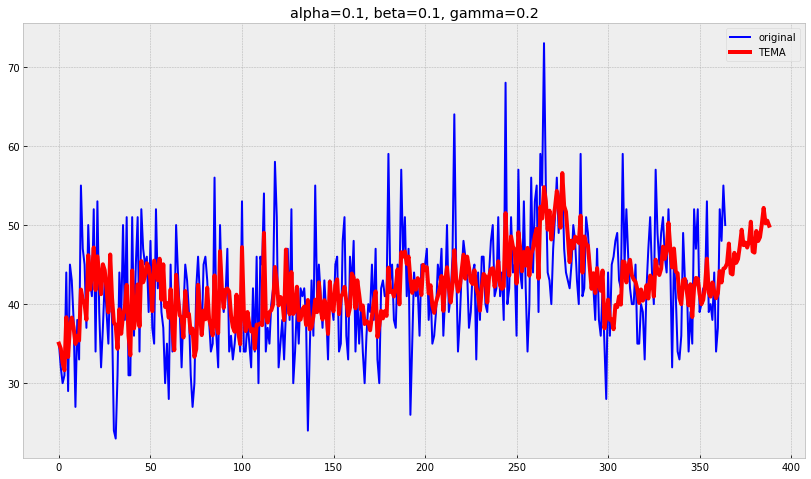

In [54]:
plot_tema(0.1, 0.1, 0.2)

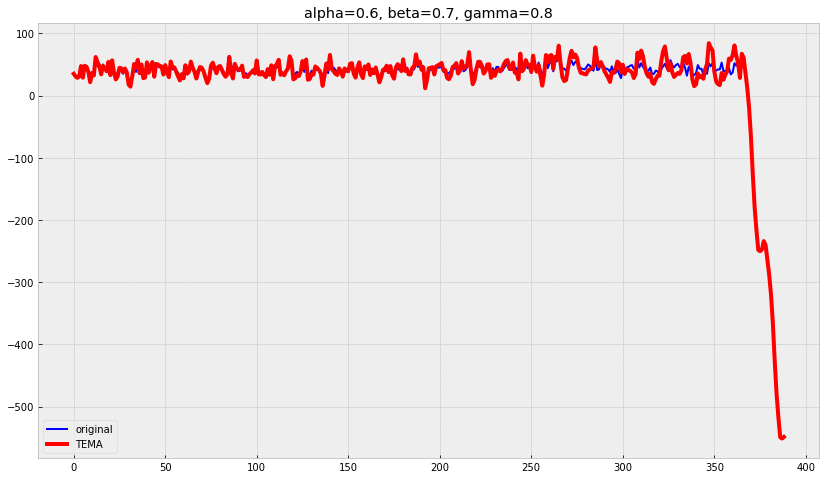

In [55]:
plot_tema(0.6, 0.7, 0.8)

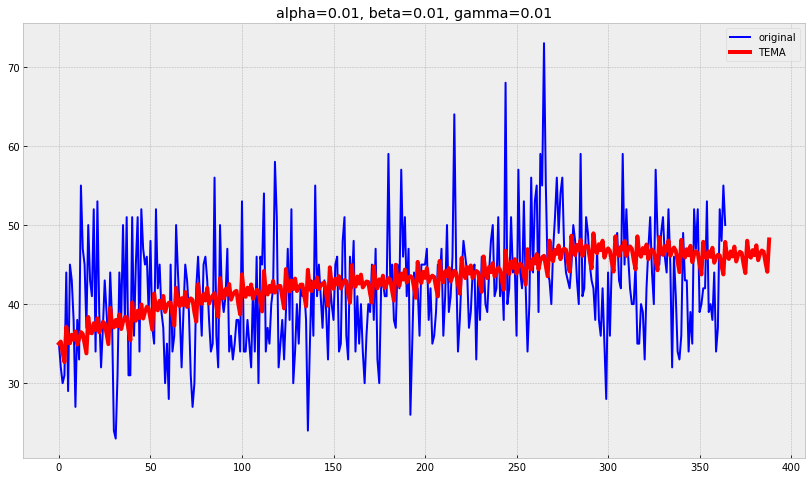

In [56]:
plot_tema(0.01, 0.01, 0.01)

Вывод : Скользящие средние хорошо подходят для определения тенденции временного ряда. Скользящие средниее представляет собой серию средних значений, рассчитанных на основе исторических данных. Скользящие средние можно рассчитать для любого количества периодов времени